In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
earth = pd.read_csv("Supplement_MnO_Cal_Input_outliers_wvl.csv")
mars = pd.read_csv("ChemCam_sol0-2890.csv")
target = pd.read_csv("ccam-libs-calibration-moc-v3-for-pds.csv")

/var/folders/rb/kxt2pvjx7bb3mg6mbyj8fhzc0000gn/T/ipykernel_26067/2518500576.py:1: DtypeWarning: Columns (1,4,5,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  earth = pd.read_csv("Supplement_MnO_Cal_Input_outliers_wvl.csv")
/var/folders/rb/kxt2pvjx7bb3mg6mbyj8fhzc0000gn/T/ipykernel_26067/2518500576.py:2: DtypeWarning: Columns (1,2,4,6,9,10,11,13,15,16,17,19,20,21,24,25,26,28,29,30,31,33,34,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  mars = pd.read_csv("ChemCam_sol0-2890.csv")


In [3]:
pd.set_option('display.max_columns', 500)
target.dropna(inplace=True)
target.head()

,Target,Spectrum Name,Sample Name,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,K2O,MOC total,Used for 2015 calibration,Used for 2021 Mn calibration,Used for 2022 Li calibration
0,AGV2,AGV2,AGV2,59.3,1.05,16.91,6.02,0.099,1.79,5.20,4.19,2.88,97.44,1.0,1.0,1.0
1,BCR-2,BCR2,BCR2,54.1,2.26,13.50,12.42,0.200,3.59,7.12,3.16,1.79,98.14,1.0,1.0,1.0
2,BEN,BEN,BEN,38.2,2.61,10.07,11.61,0.200,13.15,13.87,3.18,1.39,94.28,1.0,1.0,1.0
3,BHVO2,BHVO2,BHVO2,49.9,2.73,13.50,11.07,0.167,7.23,11.40,2.22,0.52,98.74,1.0,1.0,1.0
4,BIR-1a,BIR1,BIR1,47.7,0.97,15.40,10.19,0.176,9.7,13.40,1.81,0.03,99.38,1.0,1.0,1.0


In [4]:
n_target = target["Target"].nunique()
print(f"We have {n_target} unique targets")

We have 390 unique targets


In [5]:
'''Change object type to float'''
target = target.astype({"SiO2":float,"TiO2":float,"Al2O3":float,"FeOT":float,"MnO":float,"MgO":float,"CaO":float,"Na2O":float,"K2O":float, "MOC total":float})

In [6]:
'''add other columns for remaining composition in each target'''
new_col = 100 - target.loc[:,["MOC total"]]
target.insert(loc=12, column="other",value= new_col)
target.head()

,Target,Spectrum Name,Sample Name,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,K2O,other,MOC total,Used for 2015 calibration,Used for 2021 Mn calibration,Used for 2022 Li calibration
0,AGV2,AGV2,AGV2,59.3,1.05,16.91,6.02,0.099,1.79,5.20,4.19,2.88,2.56,97.44,1.0,1.0,1.0
1,BCR-2,BCR2,BCR2,54.1,2.26,13.50,12.42,0.200,3.59,7.12,3.16,1.79,1.86,98.14,1.0,1.0,1.0
2,BEN,BEN,BEN,38.2,2.61,10.07,11.61,0.200,13.15,13.87,3.18,1.39,5.72,94.28,1.0,1.0,1.0
3,BHVO2,BHVO2,BHVO2,49.9,2.73,13.50,11.07,0.167,7.23,11.40,2.22,0.52,1.26,98.74,1.0,1.0,1.0
4,BIR-1a,BIR1,BIR1,47.7,0.97,15.40,10.19,0.176,9.70,13.40,1.81,0.03,0.62,99.38,1.0,1.0,1.0


In [7]:
'''Dictionary of id to target names'''
id_to_target = {}
for i, t in enumerate(target["Target"]):
    id_to_target[i] = t

In [139]:
"""given a target id, return its compo as a list following the order of data frame"""
id_to_oxide = {0:"SiO2",1:"TiO2",2:"Al2O3",3:"FeOT",4:"MnO",5:"MgO",6:"CaO",7:"Na2O",8:"K2O",9:"other"}
def get_compo_as_list(target_id):
    if type(target_id)==type(1):
        return list(target.iloc[target_id,3:13])
    else:
        return list(target.loc[target["Target"]==target_id].iloc[0,3:13])

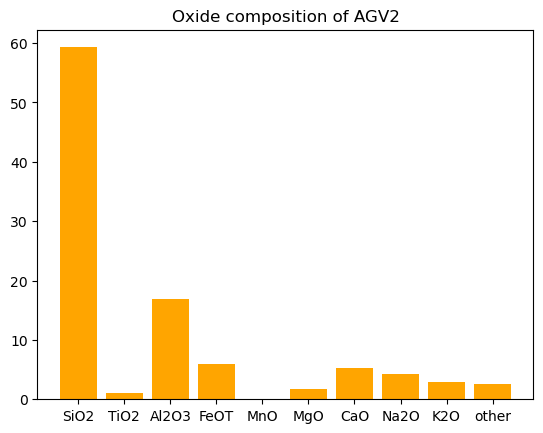

SiO2      59.3
TiO2      1.05
Al2O3    16.91
FeOT      6.02
MnO      0.099
MgO       1.79
CaO        5.2
Na2O      4.19
K2O       2.88
other     2.56
Name: values, dtype: object

In [140]:
'''Histograms of targets'''
def make_hist_target(target_id, return_values = False):
    
    if type(target_id)==type(1):
        plt.figure()
        df = pd.DataFrame({"composition":list(target.columns[3:13]), "values":target.iloc[target_id,3:13]})
        #axs[,i%2].bar(x=df["composition"], height=df["values"], color="orange")
        plt.bar(x=df["composition"], height=df["values"], color="orange")
        plt.title(f"Oxide composition of {id_to_target[target_id]}")
        plt.show()
    else:
        plt.figure()
        df = pd.DataFrame({"composition":list(target.columns[3:13]), "values":target.loc[target["Target"]==target_id].iloc[0,3:13]})
        #axs[,i%2].bar(x=df["composition"], height=df["values"], color="orange")
        plt.bar(x=df["composition"], height=df["values"], color="orange")
        plt.title(f"Oxide composition of {target_id}")
        plt.show()
        
    if return_values:
        return df["values"]
make_hist_target("AGV2", return_values=True)

In [141]:
target.loc[target["Target"]=="AGV2"].iloc[0,3:13]

SiO2      59.3
TiO2      1.05
Al2O3    16.91
FeOT      6.02
MnO      0.099
MgO       1.79
CaO        5.2
Na2O      4.19
K2O       2.88
other     2.56
Name: 0, dtype: object

In [142]:
'''filter earth spectra with targets for which composition is known'''
earth_known = earth[earth["meta"].isin(target["Target"])]
earth_known["meta"].value_counts().sort_values(ascending=True)

MIX5B          4
1413           4
MO-12          5
1426           5
GBW07315       5
              ..
Shergottite    5
Swy-1          5
SRM88b         5
Picrite        5
GBW07110       5
Name: meta, Length: 382, dtype: int64

In [11]:
# '''same for mars'''
# mars_known = mars[mars["Target"].isin(target["Target"])]
# mars_known["Target"].value_counts().sort_values(ascending=True)

In [12]:
'''define ranges of spectrometers'''
vnir_range = pd.Interval(left=492.427,right=849.0,closed="both")
vio_range = pd.Interval(left=382.13,right=473.184,closed="both")
uv_range = pd.Interval(left=246.635,right=338.457,closed="both")

In [143]:
'''dictionary of known earth targets'''
earth_target_to_ids = {}
for i, t in enumerate(earth_known["meta"]):
    if t in earth_target_to_ids:
        earth_target_to_ids[t].append(earth_known.index[i])
    else:
        earth_target_to_ids[t] = [earth_known.index[i]]

In [144]:
earth_known_id_to_target = {}
for i, target_ in enumerate(earth_target_to_ids):
    earth_known_id_to_target[i] = target_

In [145]:
for i in id_to_target.values():
    if not i in earth_target_to_ids:
        print(f"Spectra of {i} is not known")

Spectra of SANC-S is not known
Spectra of SRM98a is not known
Spectra of MHC3828 is not known
Spectra of SGR1 is not known
Spectra of VZO-114 is not known
Spectra of DC60122 is not known
Spectra of DC60123 is not known
Spectra of JSY2 is not known


In [146]:
id_to_oxide

{0: 'SiO2',
 1: 'TiO2',
 2: 'Al2O3',
 3: 'FeOT',
 4: 'MnO',
 5: 'MgO',
 6: 'CaO',
 7: 'Na2O',
 8: 'K2O',
 9: 'other'}

In [63]:
# for i in range(len(target)):
#     print(id_to_oxide[np.argmax(get_compo_as_list(i))])

In [22]:
'''only keep wavelength'''
earth_wvl = earth_known[[col for col in earth_known if col.startswith('wvl')]]
earth_wvl.columns = earth.iloc[0,-6144:]

mars_wvl = mars[[col for col in mars if col.startswith('wvl')]]
mars_wvl.columns = mars_wvl.iloc[0]
mars_wvl.drop(0,inplace=True)

/var/folders/rb/kxt2pvjx7bb3mg6mbyj8fhzc0000gn/T/ipykernel_26067/2399329457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mars_wvl.drop(0,inplace=True)


In [23]:
'''define spectra by range and normalized version for earth and mars'''
earth_vnir = earth_wvl[[cols for cols in earth_wvl if cols in vnir_range]]
earth_vnir_s = earth_vnir.div(earth_vnir.sum(axis=1), axis=0)

earth_vio = earth_wvl[[cols for cols in earth_wvl if cols in vio_range]]
earth_vio_s = earth_vio.div(earth_vio.sum(axis=1), axis=0)

earth_uv = earth_wvl[[cols for cols in earth_wvl if cols in uv_range]]
earth_uv_s = earth_uv.div(earth_uv.sum(axis=1), axis=0)

earth_s = pd.concat([earth_uv_s,earth_vio_s,earth_vnir_s], axis=1)
earth_ = pd.concat([earth_uv,earth_vio,earth_vnir], axis=1)


'''Now for Mars'''
mars_vnir = mars_wvl[[cols for cols in mars_wvl if cols in vnir_range]]
mars_vnir_s = mars_vnir.div(mars_vnir.sum(axis=1), axis=0)

mars_vio = mars_wvl[[cols for cols in mars_wvl if cols in vio_range]]
mars_vio_s = mars_vio.div(mars_vio.sum(axis=1), axis=0)

mars_uv = mars_wvl[[cols for cols in mars_wvl if cols in uv_range]]
mars_uv_s = mars_uv.div(mars_uv.sum(axis=1), axis=0)

mars_s = pd.concat([mars_uv_s,mars_vio_s,mars_vnir_s], axis=1)

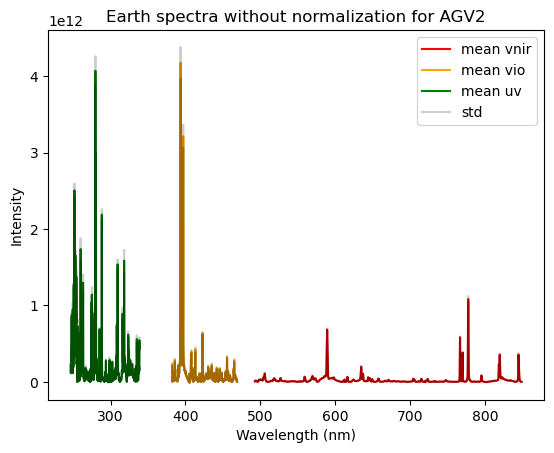

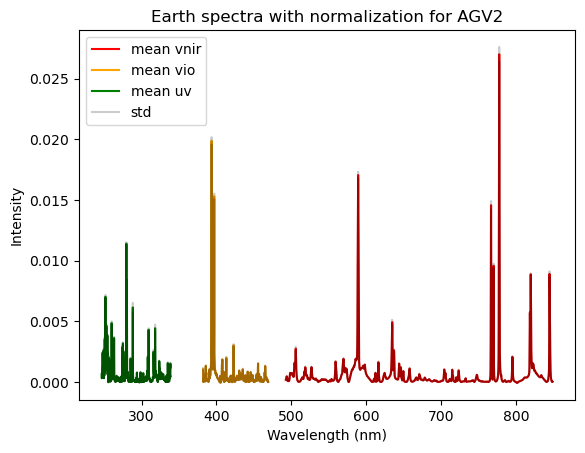

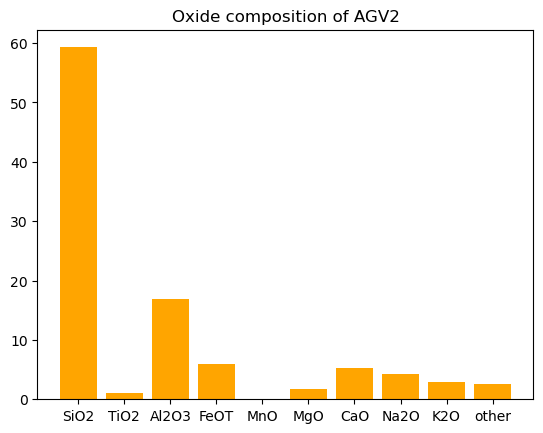

In [147]:
'''function to plot spectras

Input: 
    - target_id: integer corresponding to a unique target name
    - is_normalized: Boolean --> True if want spectras to be normalized by range (UV, VNIR, VIO)
    
Return:

    - mean spectras (per range) together with standard-deviation among the spectras 
    corresponfing to the target name.

'''

def plot_spectra_earth(target_id, is_normalized=True):
    N_spectra = len(earth_target_to_ids[id_to_target[target_id]])
    spectras_vnir = []
    spectras_uv = []
    spectras_vio = []
    
    if is_normalized:
        for ids in earth_target_to_ids[id_to_target[target_id]]:
            spectras_vnir.append(earth_vnir_s.loc[ids,:])
            spectras_uv.append(earth_uv_s.loc[ids,:])
            spectras_vio.append(earth_vio_s.loc[ids,:])

        plt.figure()
        plt.plot(earth_vnir_s.columns,np.mean(spectras_vnir,axis=0),label="mean vnir", color="red")  
        plt.plot(earth_vio_s.columns,np.mean(spectras_vio,axis=0),label="mean vio", color="orange")   ##Mean spectras by range
        plt.plot(earth_uv_s.columns,np.mean(spectras_uv,axis=0),label="mean uv", color="green")

        plt.plot(earth_vnir_s.columns,np.mean(spectras_vnir,axis=0) + np.std(spectras_vnir,axis=0), c="black",alpha=0.2)
        plt.plot(earth_vnir_s.columns,np.mean(spectras_vnir,axis=0) - np.std(spectras_vnir,axis=0),c="black",alpha=0.2)

        plt.plot(earth_vio_s.columns,np.mean(spectras_vio,axis=0) + np.std(spectras_vio,axis=0),c="black", alpha=0.2)
        plt.plot(earth_vio_s.columns,np.mean(spectras_vio,axis=0) - np.std(spectras_vio,axis=0),c="black", alpha=0.2)

        plt.plot(earth_uv_s.columns,np.mean(spectras_uv,axis=0) + np.std(spectras_uv,axis=0),label="std", alpha=0.2, c="black")
        plt.plot(earth_uv_s.columns,np.mean(spectras_uv,axis=0) - np.std(spectras_uv,axis=0), c="black",alpha=0.2)
        plt.title(f"Earth spectra with normalization for {id_to_target[target_id]}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity")
        plt.legend()
    
    else:
        for ids in earth_target_to_ids[id_to_target[target_id]]:
            spectras_vnir.append(earth_vnir.loc[ids,:])
            spectras_uv.append(earth_uv.loc[ids,:])
            spectras_vio.append(earth_vio.loc[ids,:])

        plt.figure()
        plt.plot(earth_vnir.columns,np.mean(spectras_vnir,axis=0),color="red",label="mean vnir")  
        plt.plot(earth_vio.columns,np.mean(spectras_vio,axis=0),label="mean vio", color="orange")   ##Mean spectras by range
        plt.plot(earth_uv.columns,np.mean(spectras_uv,axis=0),label="mean uv",color="green")

        plt.plot(earth_vnir.columns,np.mean(spectras_vnir,axis=0) + np.std(spectras_vnir,axis=0),label="std",c="black",alpha=0.2)
        plt.plot(earth_vnir.columns,np.mean(spectras_vnir,axis=0) - np.std(spectras_vnir,axis=0),c="black",alpha=0.2)

        plt.plot(earth_vio.columns,np.mean(spectras_vio,axis=0) + np.std(spectras_vio,axis=0),c="black",alpha=0.2)
        plt.plot(earth_vio.columns,np.mean(spectras_vio,axis=0) - np.std(spectras_vio,axis=0),c="black",alpha=0.2)

        plt.plot(earth_uv.columns,np.mean(spectras_uv,axis=0) + np.std(spectras_uv,axis=0),c="black",alpha=0.2)
        plt.plot(earth_uv.columns,np.mean(spectras_uv,axis=0) - np.std(spectras_uv,axis=0),c="black",alpha=0.2)
        plt.title(f"Earth spectra without normalization for {id_to_target[target_id]}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity")
        plt.legend()
        
        
#     plt.plot(earth_vnir_s.columns,earth_vnir_s.iloc[0,:], label="vnir")
#     plt.plot(earth_vio_s.columns,earth_vio_s.iloc[0,:], label="vio")
#     plt.plot(earth_uv_s.columns,earth_uv_s.iloc[0,:], label="uv")
#     plt.title("Earth spectra normalized")
#     plt.legend()

#     plt.figure()
#     plt.yscale("log")
#     plt.plot(earth_vnir.columns,earth_vnir.iloc[0,:], label="vnir")
#     plt.plot(earth_vio.columns,earth_vio.iloc[0,:], label="vio")
#     plt.plot(earth_uv.columns,earth_uv.iloc[0,:], label="uv")
#     plt.title("Earth spectra")
#     plt.legend()

id_ = 0
plot_spectra_earth(id_,is_normalized=False)
plot_spectra_earth(id_,is_normalized=True)
make_hist_target(id_)

In [186]:
id_ = list(id_to_target.values()).index("NAu-2-high-s")

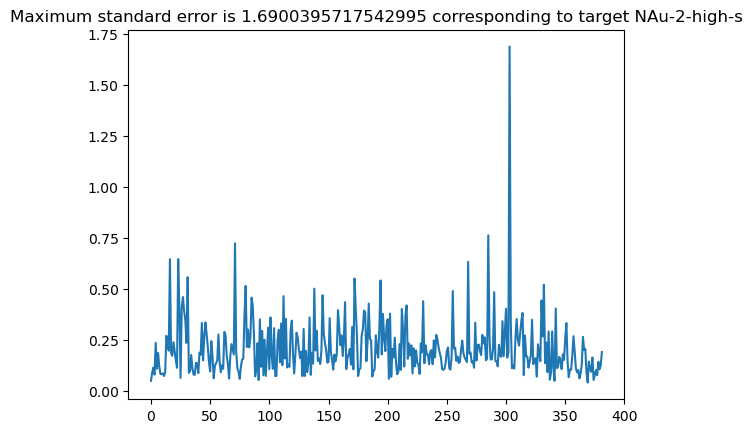

In [148]:
def plot_std(is_normalized=True):
    std_t = []
    for target in earth_target_to_ids:
        df = earth_s.loc[earth_target_to_ids[target],:]
        std_t.append(sum(df.std()))
    plt.plot(std_t)
    plt.title(f"Maximum standard error is {np.max(std_t)} corresponding to target {earth_known_id_to_target[np.argmax(std_t)]}")
         
        
plot_std()

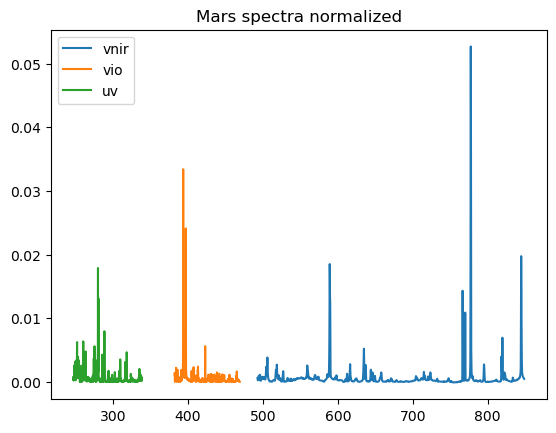

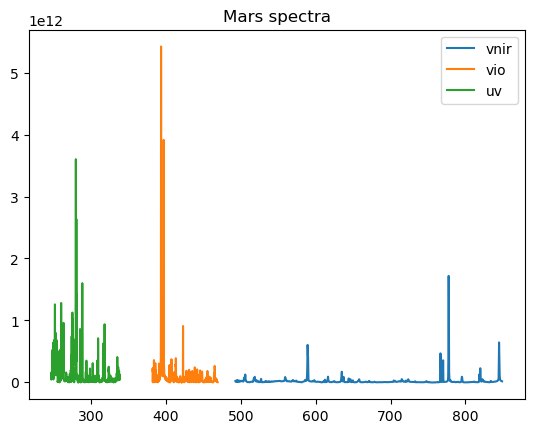

In [32]:
'''Similar plots for Mars spectra'''
spectra_id = 100
plt.plot(mars_vnir_s.columns,mars_vnir_s.iloc[spectra_id,:], label="vnir")
plt.plot(mars_vio_s.columns,mars_vio_s.iloc[spectra_id,:], label="vio")
plt.plot(mars_uv_s.columns,mars_uv_s.iloc[spectra_id,:], label="uv")
plt.title("Mars spectra normalized")
plt.legend()

plt.figure()
# plt.yscale("log")
plt.plot(mars_vnir.columns,mars_vnir.iloc[spectra_id,:], label="vnir")
plt.plot(mars_vio.columns,mars_vio.iloc[spectra_id,:], label="vio")
plt.plot(mars_uv.columns,mars_uv.iloc[spectra_id,:], label="uv")
plt.title("Mars spectra")
plt.legend()

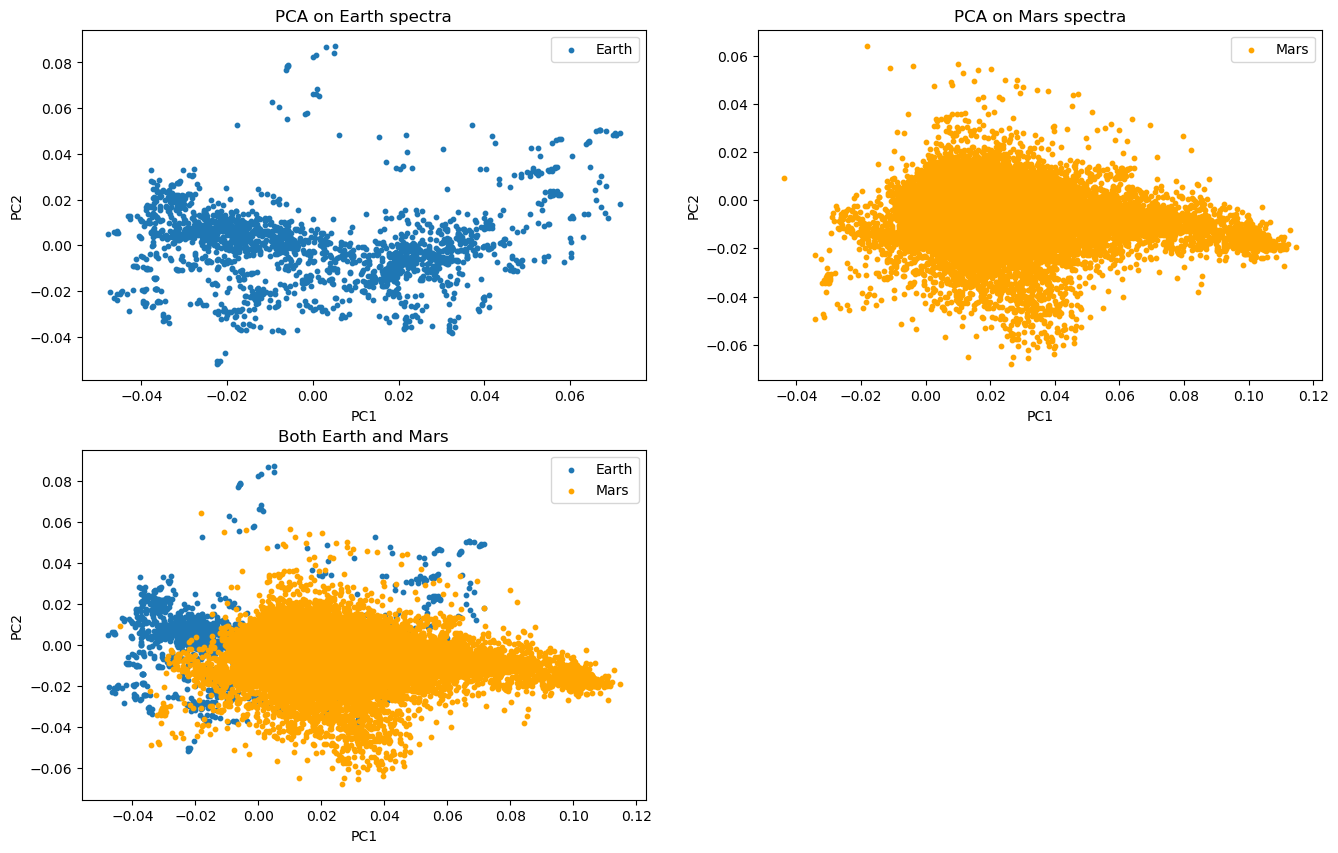

In [116]:
X_e = pd.concat([earth_uv_s,earth_vio_s,earth_vnir_s],axis=1)
X_m = pd.concat([mars_uv_s,mars_vio_s,mars_vnir_s],axis=1)
X_m.drop(columns=X_m.columns[-1:], axis=1, inplace=True)

pca = PCA(n_components=2)
#earth_concat = pd.concat([earth_vnir_s,earth_uv_s,earth_vio_s], axis=1)
X_red_earth = pca.fit_transform(X_e)
X_red_mars = pca.transform(X_m)

# Earth only
plt.figure(figsize=(16, 10)) 
ax1 = plt.subplot(2,2,1)
ax1.scatter(X_red_earth[:,0],X_red_earth[:,1],s=10, label="Earth")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
ax1.set_title("PCA on Earth spectra")

# Mars
ax2 = plt.subplot(2,2,2)
ax2.scatter(X_red_mars[:,0],X_red_mars[:,1],s=10, color="orange", label="Mars")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
ax2.set_title("PCA on Mars spectra")

# Mars and Earth
ax3 = plt.subplot(2,2,3)
ax3.scatter(X_red_earth[:,0],X_red_earth[:,1],s=10, label="Earth")
plt.scatter(X_red_mars[:,0],X_red_mars[:,1],s=10, color="orange", label="Mars")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
ax3.set_title("Both Earth and Mars")

plt.savefig("PCA_earth_mars_spectra.png")

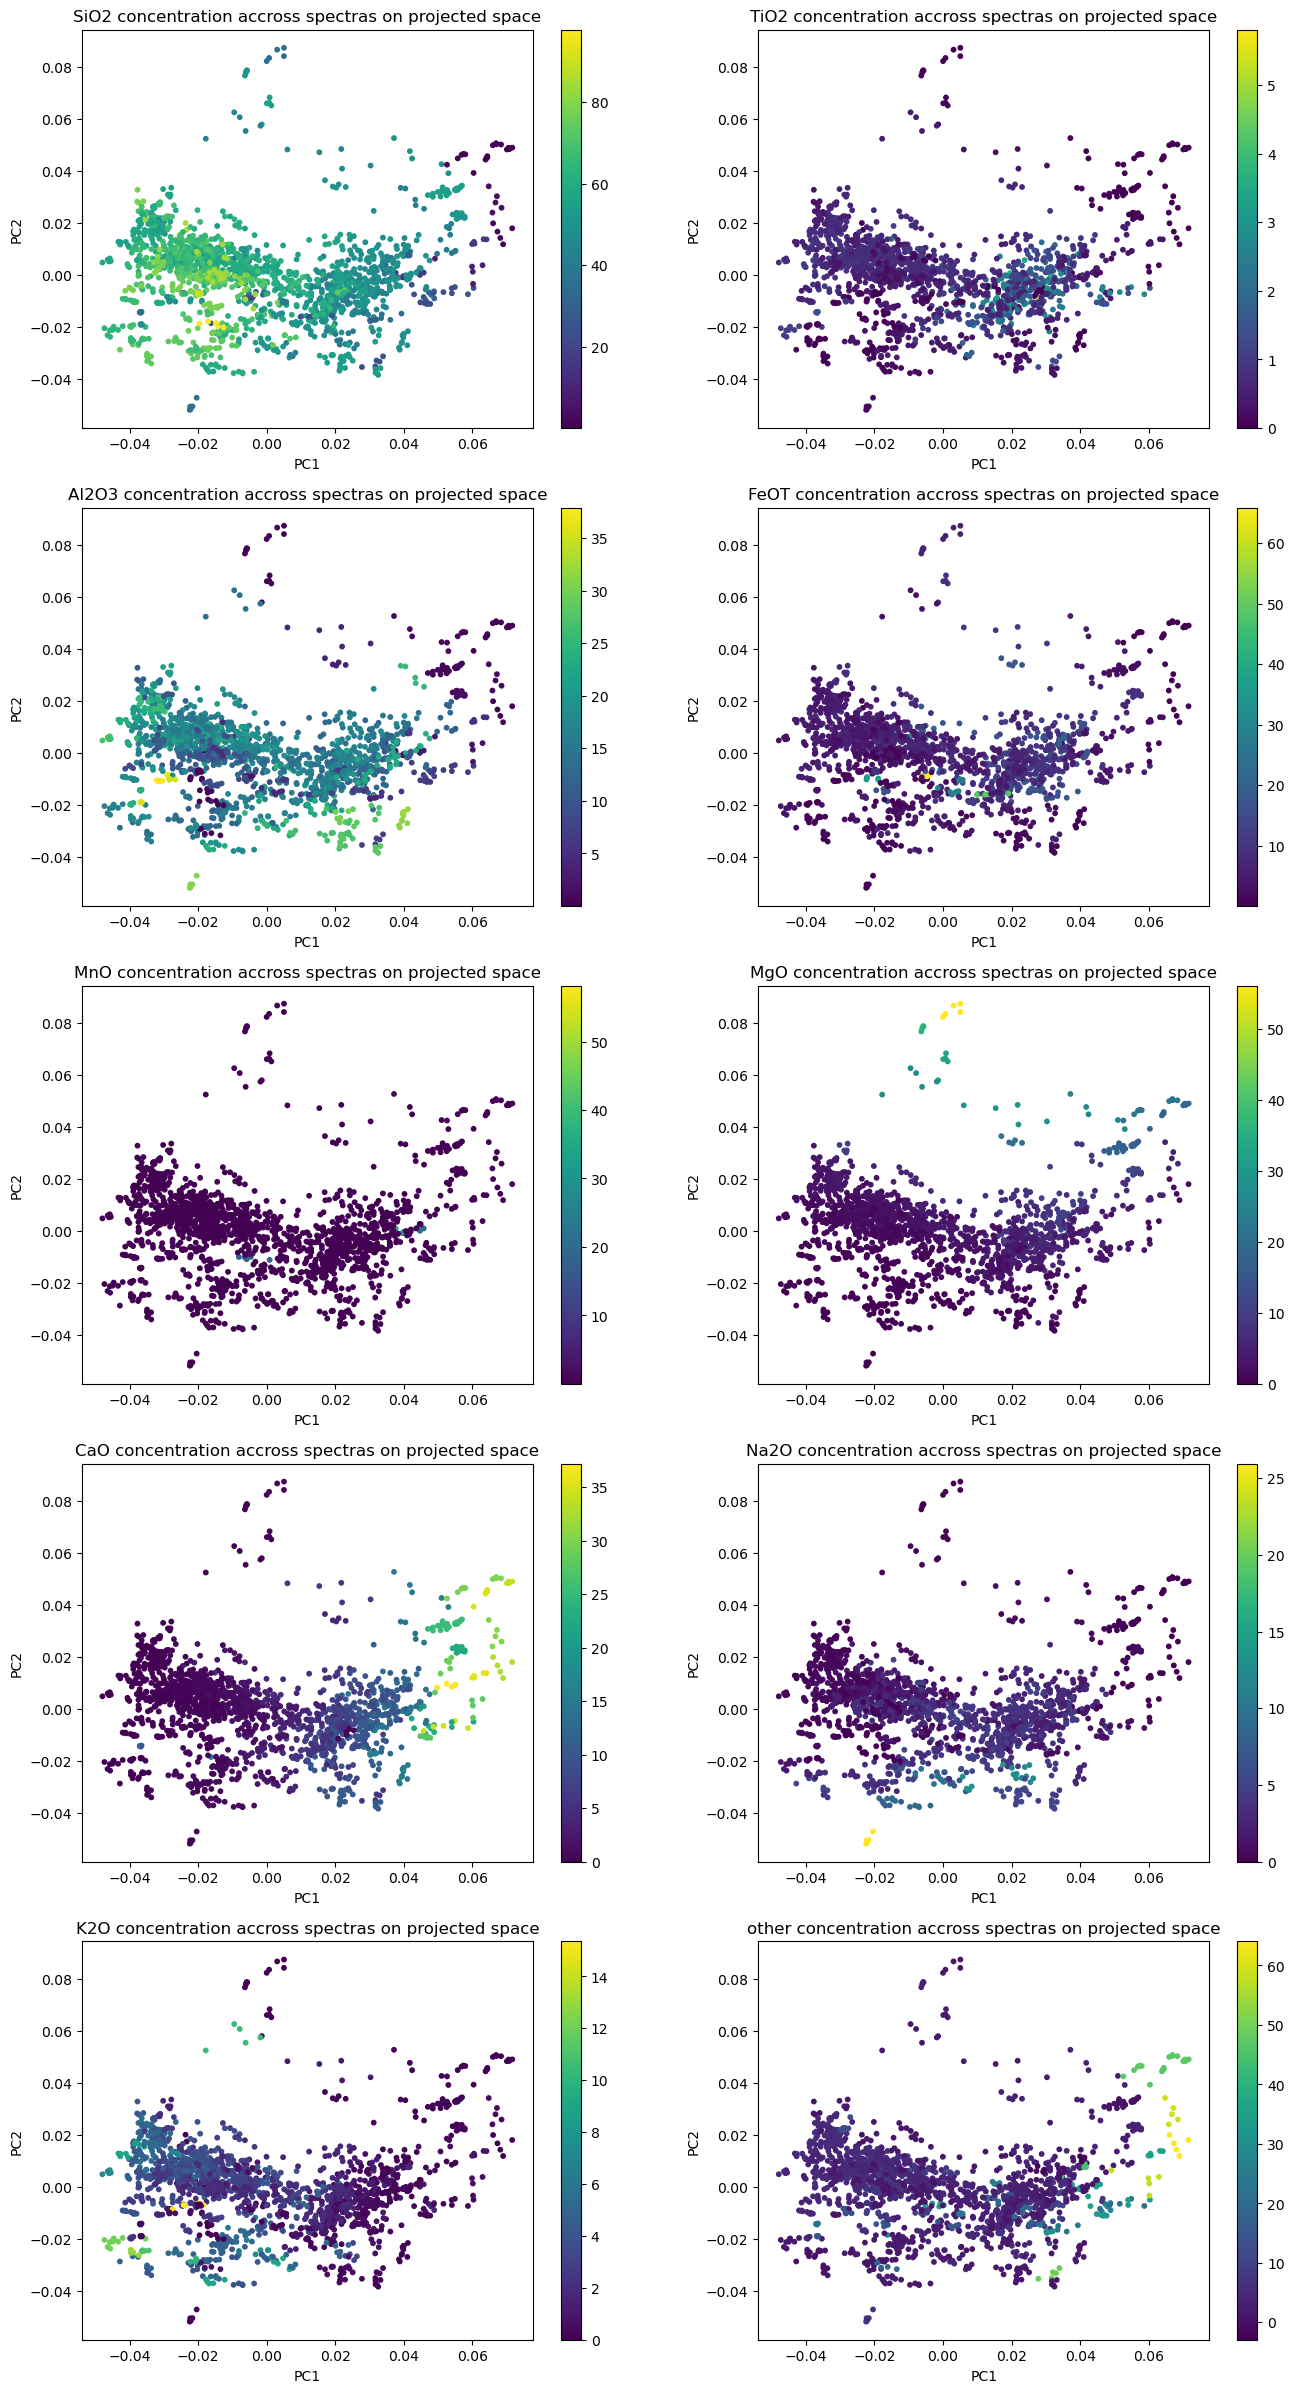

In [163]:
fig = plt.figure(figsize=(16, 30)) 

for i in range(1,11):
    ax = plt.subplot(5,2,i)
    points = ax.scatter(X_red_earth[:,0],X_red_earth[:,1],s=10, c=[get_compo_as_list(t)[i-1] \
                                                          for t in list(earth_known["meta"])])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    ax.set_title(f"{id_to_oxide[i-1]} concentration accross spectras on projected space")
    plt.colorbar(points)
# fig.text(.2, .05, text, ha='center')
